In [2]:
from __future__ import division
from timeit import default_timer as timer
from numba import jit
import scipy
import numpy as np
from numpy.random import rand
from numpy import math
import matplotlib.pyplot as plt
from numba import jit

In [2]:
def magnetization(spinconfig):
    i = int
    sum = np.float64
    sum = 0.
    size = N*N
    for i in range(0,size):
        sum += spinconfig[i]
    return (2.0*sum - size) / size

def magn(spinconfig):
    #Nx = spin.shape[0]  # Anzahl Zeilen
    #Ny = spin.shape[1]  # Anzahl Spalten
    magn = np.sum(spinconfig)  / (float(N*N))
    # magn_list.append(magn)
    return magn

def calcMagnetisation(spinconfig):
    '''Magnetization of a given configuration'''
    magnetisation=np.sum(spinconfig)
    
    return magnetisation

# initial rdm spin configuration:
def initialLattice(n):
    '''Create a nxn lattice with random spin configuration'''
    spinLattice = np.random.choice([1,-1], size=(n,n))
    return spinLattice

def coldinitialLattice(n):
    spinLattice = np.ones( (N,N), dtype=np.int64  )
    return spinLattice

def init_config(N):
        """Initialize start configuration hot or cold.
        :return: the initial config of lattice
        """
        # cold one
        if beta >= beta_c:
            spinlattice = np.ones((N, N), dtype=np.int64)
            return spinlattice
        # hot one
        else:
            spinLattice = np.random.choice([1,-1], size=(n,n))
            return spinLattice

def calcEnergy(spinconfig):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(len(spinconfig)):
        for j in range(len(spinconfig)):
            S = spinconfig[i,j]
            nb = spinconfig[(i+1)%N, j] + spinconfig[i,(j+1)%N] + spinconfig[(i-1)%N, j] + spinconfig[i,(j-1)%N]
            energy += -nb*S
    return energy/(float(N*N))

def calcB_L(Ene):
    B_L = 1 - np.sum(Ene**4) / (3 * np.sum(Ene**2)**2)
    return 

In [3]:
@jit()
def mcMetroRandom(spinconfig,n , beta):
    ''' This is to execute the monte carlo moves using 
        Metropolis algorithm such that detailed
        balance condition is satisified'''
    for i in range(n):
        for j in range(n):
            a=np.random.randint(0,n) # looping over i & j therefore use a & b
            b=np.random.randint(0,n)
            spinlattice=spinconfig[a,b]   # is initvalue of spinLattice
            
            # Periodic Boundary Condition
            neighbours=spinconfig[(a+1)%n, b] + spinconfig[a, (b+1)%n] + spinconfig[(a-1)%n, b] + spinconfig[a, (b-1)%n]
            
            # change in energy:
            Delta_E=2*spinlattice*neighbours
            
            # using acceptance test:
            if Delta_E<0:
                spinlattice=-1*spinlattice
            elif np.random.random()< np.exp(-Delta_E*beta):
                spinlattice=-1*spinlattice
            
            # anyway: satisfing the detailed balance condition, 
            # ensuring a final equilibrium state. And new config is:
            spinconfig[a,b]=spinlattice
    return spinconfig

In [3]:
#N = 64
nt = 1000 #  number of temperature points
eqSteps = 1000    #  number of MC sweeps for equilibration (default:1024)
mcSteps = 1500       #  number of MC sweeps for calculation (default:1024)

In [5]:
T = np.linspace(1., 5., nt);
T_c = 2.269
beta_c=np.log(1+np.sqrt(2))/2
T_crit = 1.0 / beta_c

beta = np.linspace(0.35, 0.5, nt)
M=np.zeros(nt)
Chi=np.zeros(nt)
B_L = np.zeros(nt)
E = np.zeros(nt)
Energy = np.zeros(nt)
C = np.zeros(nt)
B = np.zeros(nt)

In [33]:
#----------------------------------------------------------------------
#  MAIN PART OF THE CODE
#----------------------------------------------------------------------
#@jit()
for t in range(nt):
    M0=0; M1=0; M2 = 0;
    E0=0; E1=0; E2 = 0;
    #spinconfig=init_config(N)
    
    ##cold start
    spinconfig = coldinitialLattice(N)
    
    beta = 1./T[t]
    beta_square = beta *beta
    #config = initialstate(N)
    iT=1.0/T[t]; iT2=iT*iT;
    
    for i in range(eqSteps):         # equilibrate
        mcMetroRandom(spinconfig, N, beta)
        #mcmove(config, iT)           # Monte Carlo moves

    for i in range(mcSteps):
        #spinconfig = Flipflop(spinconfig)  
        mcMetroRandom(spinconfig,N,beta)
        #mcmove(config, iT)           
        #Bin = calcB_L(Ene)
        #Mag=calcMagnetisation(spinconfig)
        #Mag = calcMag(config)        # calculate the magnetisation
        Mag = abs(magn(spinconfig))
        chi = Mag * Mag
        Ene = calcEnergy(spinconfig)     # calculate the energy
        heat = Ene * Ene
    
        ### add all quantities
        #M0 += Mag  #magnetization
        M1 += chi  ## suscep
        M2 += chi * chi   ## for binder and also variance of suscep
        
        #### energystuff
        E0 += Ene ###energy
        E1 += heat ### for specific heat
        E2 += heat * heat #### for the variance of the specific heat
        
    # appending the values (before that i only have one value, but i need like )
    #E[t] = E0/(1.0 * mcSteps)
    Chi[t] = (M2/(1.0*mcSteps) - M1/(1.0 * mcSteps) * M1/(1.0 * mcSteps))*iT*N*N
    C[t] = (E2/(1.0*mcSteps) - E1/(1.0 * mcSteps) * E1/(1.0 * mcSteps))*iT2*N*N
    #M[t]=M0/(1.0 * mcSteps)
    #B_L[t] = 1.0 - (M2/(1.0*mcSteps))/(3.0 * (M1/(1.0*mcSteps)) * (M1/(1.0*mcSteps)))

In [38]:
### cold start values
###suscep
#np.savetxt('sus4_T1000_1overMC_COLD.txt', Chi )
#np.savetxt('sus8_T1000_1overMC_COLD.txt', Chi )
#np.savetxt('sus16_T1000_1overMC_COLD.txt', Chi )
#np.savetxt('sus32_T1000_1overMC_COLD.txt', Chi )
#np.savetxt('sus64_T1000_1overMC_COLD.txt', Chi )



###heat
#np.savetxt('heat4_T1000_1overMC_COLD.txt', C )
#np.savetxt('heat8_T1000_1overMC_COLD.txt', C )
#np.savetxt('heat16_T1000_1overMC_COLD.txt', C )
#np.savetxt('heat32_T1000_1overMC_COLD.txt', C )
#np.savetxt('heat64_T1000_1overMC_COLD.txt', C )

In [39]:
###suszep
Chi4 = np.loadtxt('sus4_T1000_1overMC_COLD.txt' )
Chi8 = np.loadtxt('sus8_T1000_1overMC_COLD.txt' )
Chi16 = np.loadtxt('sus16_T1000_1overMC_COLD.txt' )
Chi32 = np.loadtxt('sus32_T1000_1overMC_COLD.txt' )
Chi64 = np.loadtxt('sus64_T1000_1overMC_COLD.txt' )
#
#
####heat
C4 = np.loadtxt('heat4_T1000_1overMC_COLD.txt')
C8 = np.loadtxt('heat8_T1000_1overMC_COLD.txt')
C16 = np.loadtxt('heat16_T1000_1overMC_COLD.txt')
C32 = np.loadtxt('heat32_T1000_1overMC_COLD.txt')
C64 = np.loadtxt('heat64_T1000_1overMC_COLD.txt')

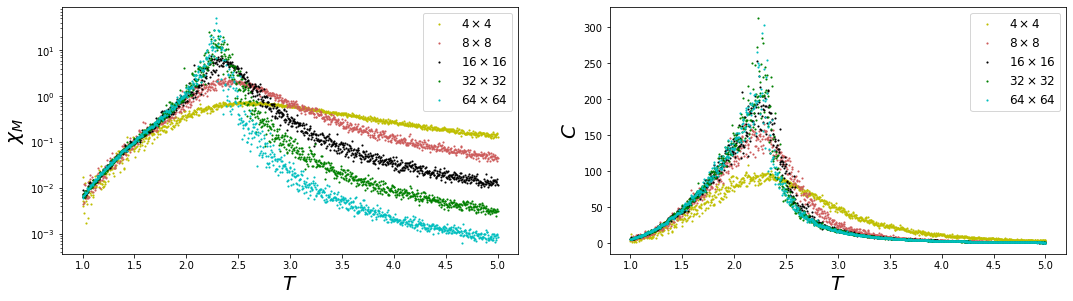

In [62]:
#### energy, suszep and heat
f = plt.figure(figsize=(18, 10)); # plot the calculated values    

#sp =  f.add_subplot(2, 2, 1 );
#plt.scatter(T, E4, s=5, marker='.', color='y')
#plt.scatter(T, E8, s=5, marker='.', color='IndianRed')
#plt.scatter(T, E16, s=5, marker='.', color='k')
#plt.xlabel("Temperature (T)", fontsize=20);
#plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, Chi4, s=5, marker='.', color='y', label= r'$4 \times 4$')
plt.scatter(T, Chi8, s=5, marker='.', color='IndianRed' , label= r'$8 \times 8$')
plt.scatter(T, Chi16 , s=5, marker='.', color='k'  , label= r'$16 \times 16$')
plt.scatter(T, Chi32, s=5, marker='.', color='green' , label= r'$32\times 32$')
plt.scatter(T, Chi64, s=5, marker='.', color='c' , label= r'$64 \times 64$')
#plt.vlines(2.269, -0.001  , 10 , linestyles='dashed', alpha=0.5);
#plt.scatter(T, M128, s=5, marker='.', color='b')
plt.yscale('log')
plt.legend(loc = 'best', fontsize=12)
plt.xlabel(r"$T$", fontsize=20);
plt.ylabel(r"$\chi _M$ ", fontsize=20);         plt.axis('tight');


sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, C4, s=5, marker='.', color='y', label= r'$4 \times 4$')
plt.scatter(T, C8, s=5, marker='.', color='IndianRed' , label= r'$8 \times 8$')
plt.scatter(T, C16 , s=5, marker='.', color='k'  , label= r'$16 \times 16$')
plt.scatter(T, C32, s=5, marker='.', color='green' , label= r'$32\times 32$')
plt.scatter(T, C64, s=5, marker='.', color='c' , label= r'$64 \times 64$')
plt.legend(loc = 'best', fontsize=12)
#plt.vlines(2.269, -20  , 350 , linestyles='dashed', alpha=0.5);
plt.xlabel(r"$T$", fontsize=20);
plt.ylabel(r"$C$ ", fontsize=20);         plt.axis('tight');

#plt.savefig('chiANDc_T=1000_1500MC_1000EQ_COLD.pdf',format='pdf')

In [138]:
###critical exponents ising for d=2:
alpha = 0.0
beta = 0.125 ##1/8
gamma = 1.75
nu = 1.0

L4= 4
scaleT4 = L4*(T-T_crit)  
scaley4 = L4**(-gamma)

L8= 8
scaleT8 = L8*(T-T_crit)   
scaley8 = L8**(-gamma)

L16= 16
scaleT16 = L16*(T-T_crit)  
scaley16 = L16**(-gamma)

L32= 32
scaleT32 = L32*(T-T_crit)   
scaley32 = L32**(-gamma)

L64= 64
scaleT64 = L64*(T-T_crit)   
scaley64 = L64**(-gamma)

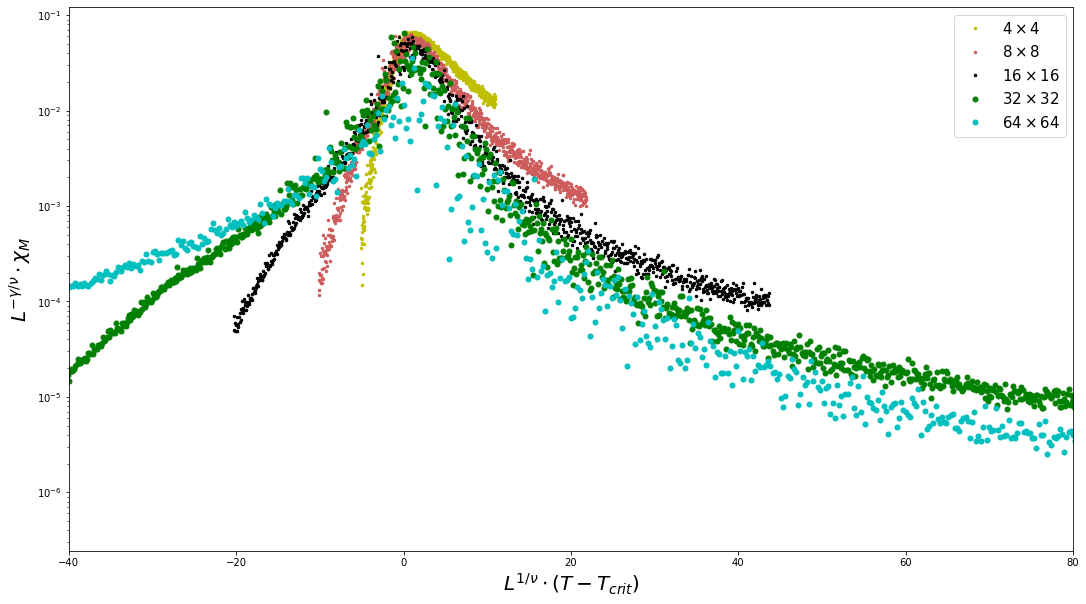

In [148]:
 
#f = plt.figure(figsize=(18, 10)); # plot the calculated values    

#sp =  f.add_subplot(2, 2, 1 );
#plt.scatter(T, E4, s=5, marker='.', color='y')
#plt.scatter(T, E8, s=5, marker='.', color='IndianRed')
#plt.scatter(T, E16, s=5, marker='.', color='k')
#plt.xlabel("Temperature (T)", fontsize=20);
#plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

#sp =  f.add_subplot(2, 2, 1 );
fig = plt.figure(figsize=(18,10) )

plt.plot(scaleT4, scaley4*Chi4, ms=5, ls= '',  marker='.', color='y', label= r'$4 \times 4$')
plt.plot(scaleT8, scaley8*Chi8,ms=5, ls= '', marker='.', color='IndianRed' , label= r'$8 \times 8$')
plt.plot(scaleT16, scaley16 * Chi16 ,ms=5, ls= '', marker='.', color='k'  , label= r'$16 \times 16$')
plt.plot(scaleT32, scaley32 *Chi32,ms=5 , ls= '', marker='o', color='green' , label= r'$32\times 32$')
plt.plot(scaleT64, scaley64 *Chi64, ms=5, ls= '', marker='o', color='c' , label= r'$64 \times 64$')

#plt.vlines(2.269, -0.001  , 10 , linestyles='dashed', alpha=0.5);
#plt.scatter(T, M128, s=5, marker='.', color='b')
plt.yscale('log')
plt.legend(loc = 'best', fontsize=15)
plt.xlabel(r"$L^{1/\nu}\cdot (T-T_{crit})$", fontsize=20);
plt.ylabel(r"$L^{-\gamma/\nu}\cdot \chi _M$ ", fontsize=20);         plt.axis('tight');

plt.xlim( -40,80)
#plt.savefig('chiFSS_T=1000_1500MC_1000EQ_COLD.pdf',format='pdf')
plt.show()

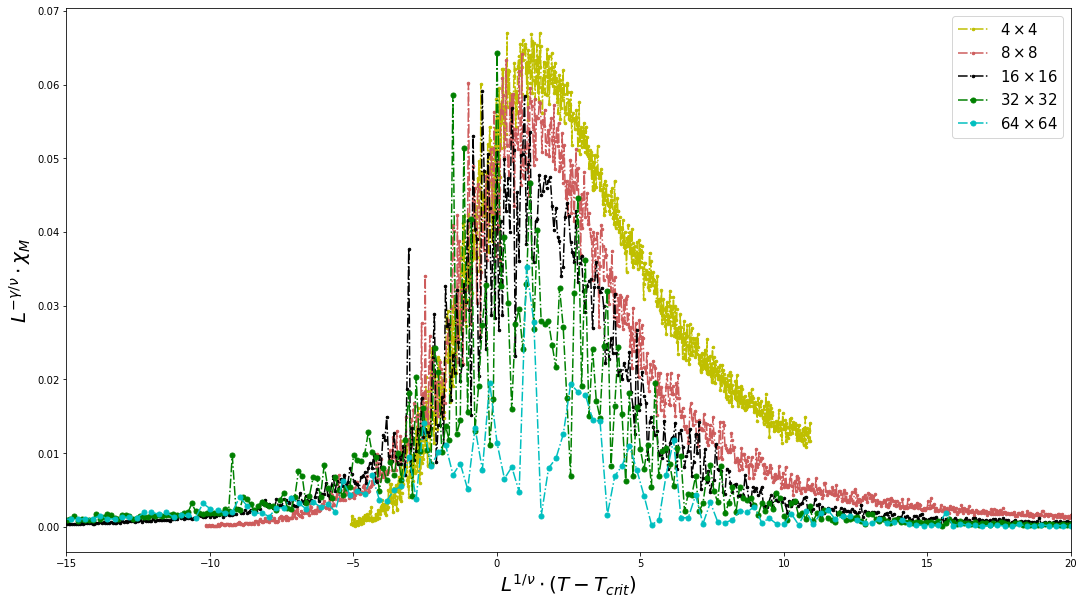

In [149]:
fig = plt.figure(figsize=(18,10) )

plt.plot(scaleT4, scaley4*Chi4, ms=5, ls= '-.',  marker='.', color='y', label= r'$4 \times 4$')
plt.plot(scaleT8, scaley8*Chi8,ms=5, ls= '-.', marker='.', color='IndianRed' , label= r'$8 \times 8$')
plt.plot(scaleT16, scaley16 * Chi16 ,ms=5, ls= '-.', marker='.', color='k'  , label= r'$16 \times 16$')
plt.plot(scaleT32, scaley32 *Chi32,ms=5 , ls= '-.', marker='o', color='green' , label= r'$32\times 32$')
plt.plot(scaleT64, scaley64 *Chi64, ms=5, ls= '-.', marker='o', color='c' , label= r'$64 \times 64$')

#plt.vlines(2.269, -0.001  , 10 , linestyles='dashed', alpha=0.5);
#plt.scatter(T, M128, s=5, marker='.', color='b')
#plt.yscale('log')
plt.legend(loc = 'best', fontsize=15)
plt.xlabel(r"$L^{1/\nu}\cdot (T-T_{crit})$", fontsize=20);
plt.ylabel(r"$L^{-\gamma/\nu}\cdot \chi _M$ ", fontsize=20);         plt.axis('tight');

plt.xlim( -15,20)
#plt.savefig('chiFSS_zoom_T=1000_1500MC_1000EQ_COLD.pdf',format='pdf')
plt.show()

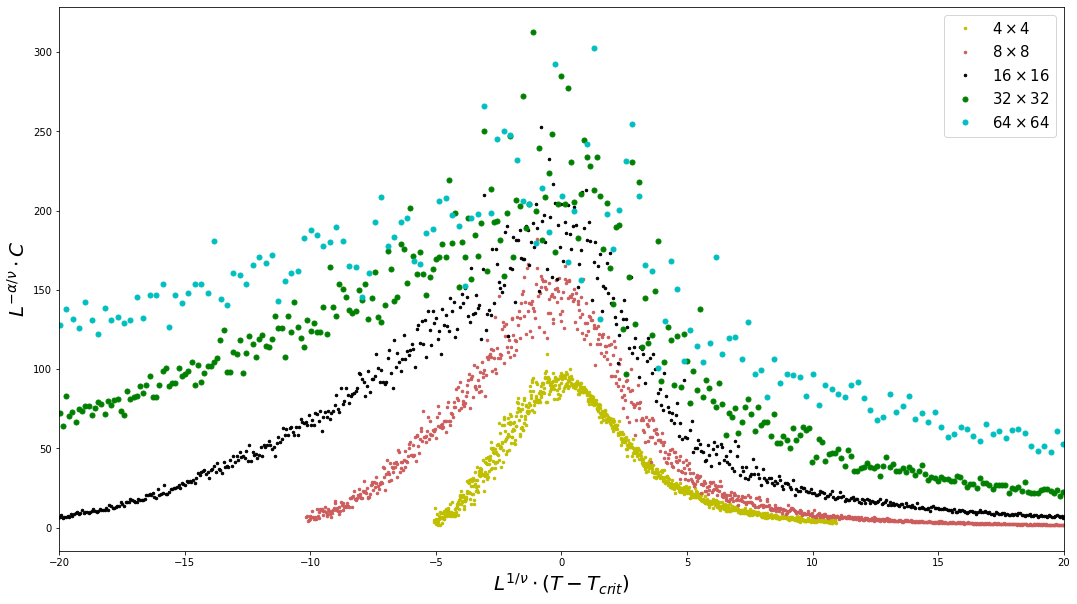

In [150]:
x4 = (T-T_crit)*L4
x8 = (T-T_crit)*L8
x16 = (T-T_crit)*L16
x32 = (T-T_crit)*L32
x64 = (T-T_crit)*L64

fig = plt.figure(figsize=(18,10) )

plt.plot(x4, C4, ms=5, ls= '',  marker='.', color='y', label= r'$4 \times 4$')
plt.plot(x8, C8,ms=5, ls= '', marker='.', color='IndianRed' , label= r'$8 \times 8$')
plt.plot(x16, C16 ,ms=5, ls= '', marker='.', color='k'  , label= r'$16 \times 16$')
plt.plot(x32, C32,ms=5 , ls= '', marker='o', color='green' , label= r'$32\times 32$')
plt.plot(x64, C64, ms=5, ls= '', marker='o', color='c' , label= r'$64 \times 64$')

#plt.vlines(2.269, -0.001  , 10 , linestyles='dashed', alpha=0.5);
#plt.scatter(T, M128, s=5, marker='.', color='b')
#plt.yscale('log')
plt.legend(loc = 'best', fontsize=15)
plt.xlabel(r"$L^{1/\nu}\cdot (T-T_{crit})$", fontsize=20);
plt.ylabel(r"$L^{-\alpha/\nu}\cdot C$ ", fontsize=20);         plt.axis('tight');

plt.xlim( -20,20)
#plt.savefig('heatFSS_zoom_T=1000_1500MC_1000EQ_COLD.pdf',format='pdf')
plt.show()

# Cold start_ 1000MC-Steps

In [23]:
#mag4 = np.loadtxt('mag4_T1000_1overMC.txt')
#mag8 = np.loadtxt('mag8_T1000_1overMC.txt')
#mag16 = np.loadtxt('mag16_T1000_1overMC_COLD.txt')
#mag32 = np.loadtxt('mag32_T1000_1overMC_COLD.txt')
#mag64 = np.loadtxt('mag64_T1000_1overMC_COLD.txt')
#mag128 = np.loadtxt('mag128_T1000_1overMC_COLD.txt')


###suszep
#Chi4 = np.loadtxt('sus4_T1000_1overMC_COLD.txt' )
#Chi8 = np.loadtxt('sus8_T1000_1overMC_COLD.txt' )
#Chi16 = np.loadtxt('sus16_T1000_1overMC_COLD.txt' )
#Chi32 = np.loadtxt('sus32_T1000_1overMC_COLD.txt' )
#Chi64 = np.loadtxt('sus64_T1000_1overMC_COLD.txt' )
#


####heat
#C4 = np.loadtxt('heat4_T1000_1overMC_COLD.txt')
#C8 = np.loadtxt('heat8_T1000_1overMC_COLD.txt')
#C16 = np.loadtxt('heat16_T1000_1overMC_COLD.txt')
#C32 = np.loadtxt('heat32_T1000_1overMC_COLD.txt')
#C64 = np.loadtxt('heat64_T1000_1overMC_COLD.txt')
#

##energie
#e4 = np.loadtxt('en4_T1000_1overMC.txt')
#e8 = np.loadtxt('en8_T1000_1overMC.txt')
#e16 = np.loadtxt('en16_T1000_1overMC.txt')
#e32 = np.loadtxt('en32_T1000_1overMC_COLD.txt')
#e64 = np.loadtxt('en64_T1000_1overMC_COLD.txt')


###binder
bk4 = np.loadtxt('binder4_T1000_1overMC.txt')
bk8 = np.loadtxt('binder8_T1000_1overMC.txt')
bk16 = np.loadtxt('binder16_T1000_1overMC_COLD.txt')
bk32 = np.loadtxt('binder32_T1000_1overMC_COLD.txt')
bk64 = np.loadtxt('binder64_T1000_1overMC_COLD.txt')
bk128 = np.loadtxt('binder128_T1000_1overMC_COLD.txt')

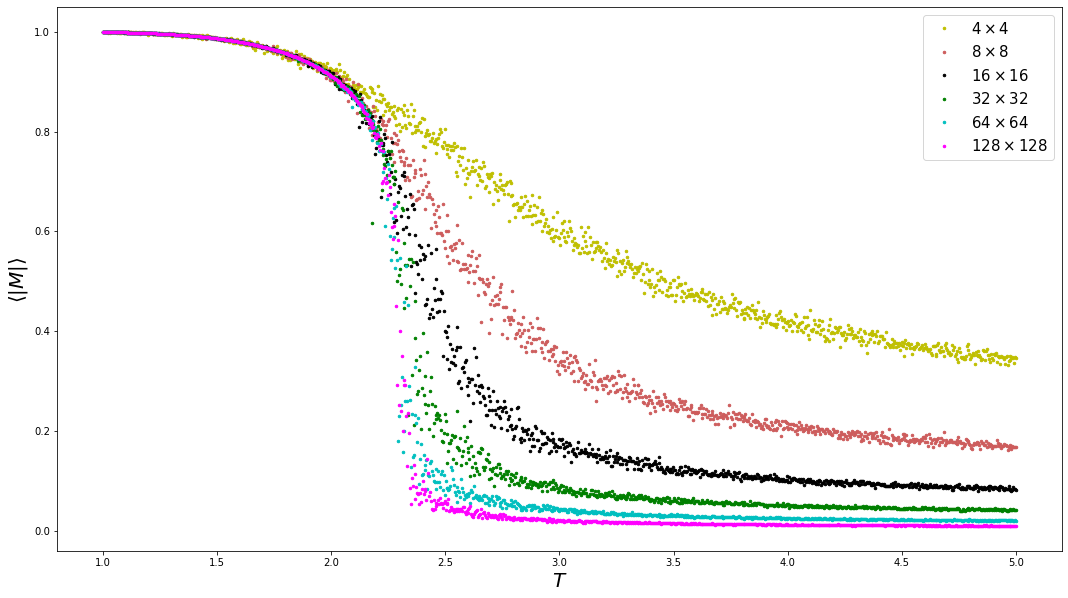

In [11]:
##magnetisation

fig = plt.figure(figsize=(18,10) )

plt.plot(T, abs(mag4), ms=5, ls= '',  marker='.', color='y', label= r'$4 \times 4$')
plt.plot(T, abs(mag8), ms=5, ls= '', marker='.', color='IndianRed' , label= r'$8 \times 8$')
plt.plot(T, abs(mag16) ,ms=5, ls= '', marker='.', color='k'  , label= r'$16 \times 16$')
plt.plot(T, abs(mag32), ms=5 , ls= '', marker='.', color='green' , label= r'$32\times 32$')
plt.plot(T, abs(mag64), ms=5, ls= '', marker='.', color='c' , label= r'$64 \times 64$')
plt.plot(T, abs(mag128), ms=5, ls= '', marker='.', color='magenta' , label= r'$128 \times 128$')

#plt.vlines(2.269, -0.001  , 10 , linestyles='dashed', alpha=0.5);
#plt.scatter(T, M128, s=5, marker='.', color='b')
#plt.yscale('log')
plt.legend(loc = 'best', fontsize=15)
plt.xlabel(r"$T$", fontsize=20);
plt.ylabel(r"$ \langle \vert M \vert \rangle$ ", fontsize=20);         plt.axis('tight');

#plt.xlim( -15,20)
#plt.savefig('absM_T=1000_1500MC_1000EQ_COLD.pdf',format='pdf')
plt.show()

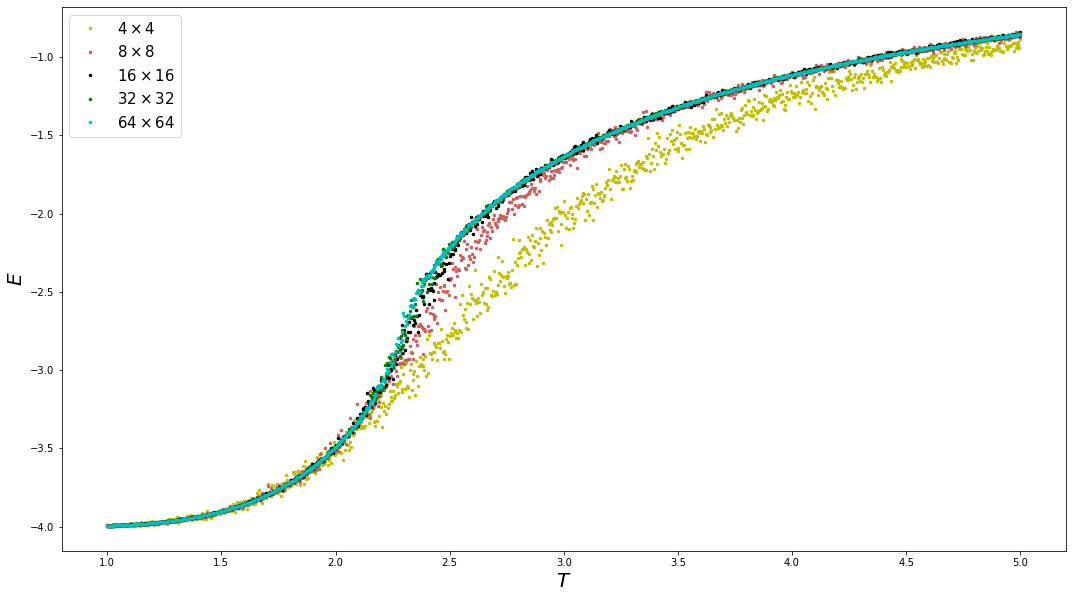

In [14]:
##energie

fig = plt.figure(figsize=(18,10) )

plt.plot(T, e4, ms=5, ls= '',  marker='.', color='y', label= r'$4 \times 4$')
plt.plot(T, e8, ms=5, ls= '', marker='.', color='IndianRed' , label= r'$8 \times 8$')
plt.plot(T, e16 ,ms=5, ls= '', marker='.', color='k'  , label= r'$16 \times 16$')
plt.plot(T, e32, ms=5 , ls= '', marker='.', color='green' , label= r'$32\times 32$')
plt.plot(T, e64, ms=5, ls= '', marker='.', color='c' , label= r'$64 \times 64$')

#plt.vlines(2.269, -0.001  , 10 , linestyles='dashed', alpha=0.5);
#plt.scatter(T, M128, s=5, marker='.', color='b')
#plt.yscale('log')
plt.legend(loc = 'best', fontsize=15)
plt.xlabel(r"$T$", fontsize=20);
plt.ylabel(r"$E$ ", fontsize=20);         plt.axis('tight');

#plt.xlim( -15,20)
#plt.savefig('E_T=1000_1500MC_1000EQ_COLD.pdf',format='pdf')
plt.show()

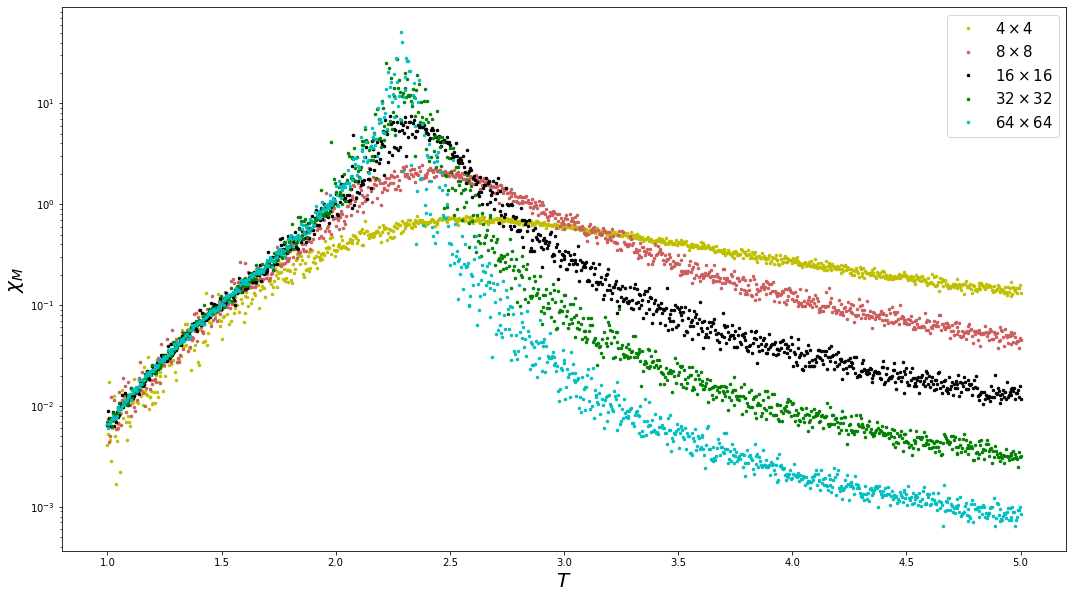

In [18]:
##suszep

fig = plt.figure(figsize=(18,10) )

plt.plot(T, Chi4, ms=5, ls= '', marker='.', color='y', label= r'$4 \times 4$')
plt.plot(T, Chi8, ms=5,ls= '',  marker='.', color='IndianRed' , label= r'$8 \times 8$')
plt.plot(T, Chi16 , ms=5,ls= '',  marker='.', color='k'  , label= r'$16 \times 16$')
plt.plot(T, Chi32, ms=5,ls= '',  marker='.', color='green' , label= r'$32\times 32$')
plt.plot(T, Chi64, ms=5,ls= '',  marker='.', color='c' , label= r'$64 \times 64$')
#plt.vlines(2.269, -0.001  , 10 , linestyles='dashed', alpha=0.5);
#plt.scatter(T, M128, s=5, marker='.', color='b')
plt.yscale('log')
plt.legend(loc = 'best', fontsize=15)
plt.xlabel(r"$T$", fontsize=20);
plt.ylabel(r"$\chi _M$ ", fontsize=20);         plt.axis('tight');


#plt.xlim( -15,20)
#plt.savefig('chi_T=1000_1500MC_1000EQ_COLD.pdf',format='pdf')
plt.show()

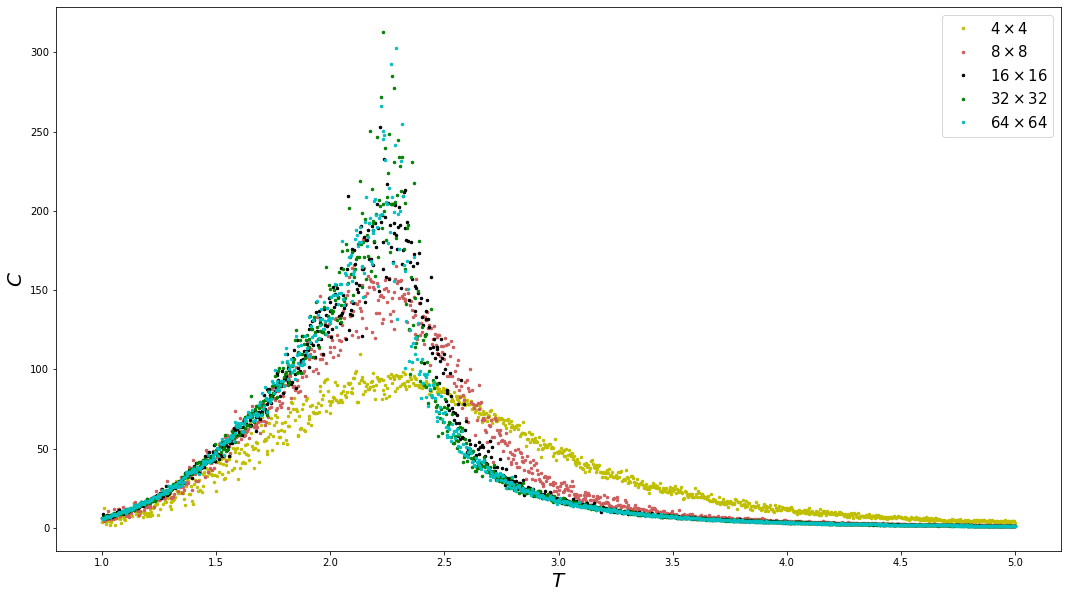

In [22]:
##heat

fig = plt.figure(figsize=(18,10) )

plt.plot(T, C4, ms=5, ls= '', marker='.', color='y', label= r'$4 \times 4$')
plt.plot(T, C8, ms=5,ls= '',  marker='.', color='IndianRed' , label= r'$8 \times 8$')
plt.plot(T, C16 , ms=5,ls= '',  marker='.', color='k'  , label= r'$16 \times 16$')
plt.plot(T, C32, ms=5,ls= '',  marker='.', color='green' , label= r'$32\times 32$')
plt.plot(T, C64, ms=5,ls= '',  marker='.', color='c' , label= r'$64 \times 64$')
#plt.vlines(2.269, -0.001  , 10 , linestyles='dashed', alpha=0.5);
#plt.scatter(T, M128, s=5, marker='.', color='b')
#plt.yscale('log')
plt.legend(loc = 'best', fontsize=15)
plt.xlabel(r"$T$", fontsize=20);
plt.ylabel(r"$C$ ", fontsize=20);         plt.axis('tight');


#plt.xlim( -15,20)
#plt.savefig('C_T=1000_1500MC_1000EQ_COLD.pdf',format='pdf')
plt.show()

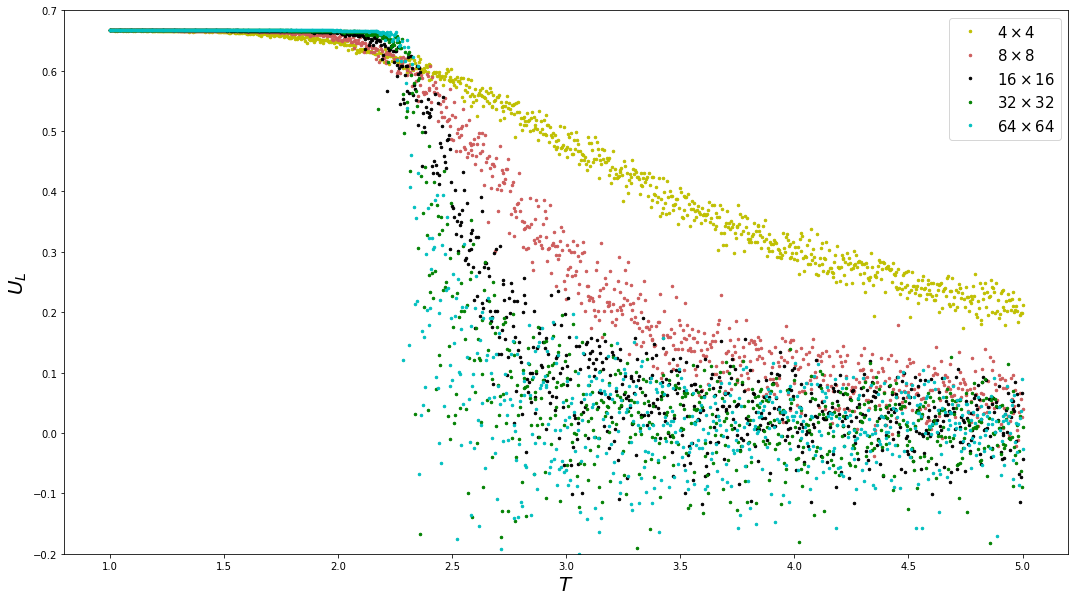

In [27]:
##binder

fig = plt.figure(figsize=(18,10) )

plt.plot(T, bk4, ms=5, ls= '', marker='.', color='y', label= r'$4 \times 4$')
plt.plot(T, bk8, ms=5,ls= '',  marker='.', color='IndianRed' , label= r'$8 \times 8$')
plt.plot(T, bk16 , ms=5,ls= '',  marker='.', color='k'  , label= r'$16 \times 16$')
plt.plot(T, bk32, ms=5,ls= '',  marker='.', color='green' , label= r'$32\times 32$')
plt.plot(T, bk64, ms=5,ls= '',  marker='.', color='c' , label= r'$64 \times 64$')
#plt.plot(T, bk128, ms=5, ls= '', marker='.', color='magenta' , label= r'$128 \times 128$')
#plt.vlines(2.269, -0.001  , 10 , linestyles='dashed', alpha=0.5);
#plt.scatter(T, M128, s=5, marker='.', color='b')
#plt.yscale('log')
plt.legend(loc = 'best', fontsize=15)
plt.xlabel(r"$T$", fontsize=20);
plt.ylabel(r"$U_L$ ", fontsize=20);         plt.axis('tight');


plt.ylim( -0.2,0.7)
#plt.savefig('C_T=1000_1500MC_1000EQ_COLD.pdf',format='pdf')
plt.show()